<a href="https://colab.research.google.com/github/manishbayesian/bayesianbookpub/blob/main/Chapter1_BayesCalculator%2C_Examples_X_XX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 1: Bayes Theorem & Examples X-XX. 
A simple calculator usingn Bayes' Theorem, and its applications as in Examples X through XX.

In [1]:
from scipy import special
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
import numpy as np

sns.set_theme(style="darkgrid")
pd.set_option('display.precision', 3)
pd.set_option('display.float_format',  '{:,.3f}'.format)

In [17]:
class BayesCalculator:
  """
  Simple class that allows update of (posterior) based on
  """

  def __init__(self, hypotheses, prior=None):
      """Prints what the animals name is and what sound it makes.

        If the argument `sound` isn't passed in, the default Animal
        sound is used.

        Parameters
        ----------
        sound : str, optional
            The sound the animal makes (default is None)
        """
      if  prior is None:
        prior = np.ones(len(hypotheses))
      else:
        assert len(prior) == len(hypotheses), 'len(hypotheses) == len(prior)'
        prior = np.asarray(prior)
      prior = prior/sum(prior)
      self._bayes_df = pd.DataFrame(prior, index=hypotheses, columns=['prior'])
     
      self._bayes_df['likelihood'] = np.nan
      self._bayes_df['evidence'] = np.nan
      self._bayes_df['posterior'] = prior.copy()
      self._likelihoods = pd.DataFrame(index=hypotheses)


  def set_likelihood(self, data, likelihood):
      assert len(likelihood) == len(self._bayes_df.index), 'len(likelihood) == len(self.hypotheses)'
      self._likelihoods[data] = np.asarray(likelihood)
      return self

  def prior(self):
    return self._bayes_df['prior']

  def posterior(self):
    return self._bayes_df['posterior']

  def evidence(self):
    return self._bayes_df['evidence'][0]

  def get_likelihood(self, data):
    return self._likelihoods[data]

  def likelihoods(self):
    return self._likelihoods

  def as_table(self):
    return self._bayes_df
  
  def update(self, data, likelihood=None):
    if likelihood is None:
      likelihood = self._likelihoods[data]
    self._bayes_df['likelihood'] = likelihood
    unscaled_posterior = self._bayes_df['prior'] * likelihood    
    self._bayes_df['evidence']  = sum(unscaled_posterior)
    self._bayes_df['posterior'] = unscaled_posterior/sum(unscaled_posterior)
    return self



## Example 12: Is the Coin Biased or Not ?
For this example, we will take two hypotheses: `U` corresponds to unbiased, with heads/tails being equally likely, and `B` corresponds to a coin that always turns up heads. 

In [8]:
coin_toss = BayesCalculator(['U','B'],prior=[0.5,0.5]) \
              .update('HHH',likelihood=[0.5*0.5*0.5, 1.0])
display(coin_toss.as_table())

,prior,likelihood,evidence,posterior
U,0.500,0.125,0.562,0.111
B,0.500,1.000,0.562,0.889


Now suppose instead of a bias of $1$ (always turning up heads), let's set the bias to $p$, i.e. it is $1/p$ times more likely to be heads. Note that $p$ is a known quantity in this analysis, but we will plot the evidence and posterior probabilities as a function of $p$.

In [18]:
biases = np.linspace(0,1.,100)
evidences = []
posterior_U = []
posterior_B = []
for p in biases:
  coin_toss = BayesCalculator(['U','B'],prior=[0.5,0.5]) \
              .update('HHH',likelihood=[0.5*0.5*0.5, p*p*p])
  evidences.append(coin_toss.evidence())
  posterior_U.append(coin_toss.posterior()['U'])
  posterior_B.append(coin_toss.posterior()['B'])

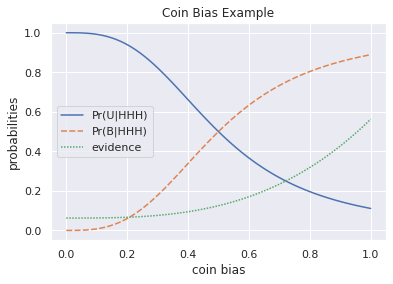

In [19]:
test_res = pd.DataFrame({'Pr(U|HHH)': posterior_U, 
                              'Pr(B|HHH)': posterior_B,
                              'evidence': evidences}, index=biases)
sns.lineplot(data=test_res).set(xlabel='coin bias',
                                     ylabel='probabilities',
                                     title='Coin Bias Example')
plt.show()

## Example 12 - Can we predict eye color from hair color?
Here we load aggregate data (of numbers of people with certain eye/hair color combinations)

In [4]:
! git clone https://github.com/manishbayesian/bayesianbookpub.git

Cloning into 'bayesianbookpub'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 3), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [5]:
eyes_hair_agg = pd.read_csv('bayesianbookpub/datasets/eye_hair_colors_aggregated.csv',index_col='Eye Color')
eyes_hair_agg

,Light Hair,Dark Hair
Eye Color,,
Green,144,181
Hazel,114,366
Blue,549,556
Brown,159,941
Other,2,9


###### First we create a helper function, that allows us to create a BayesCalculator from aggregate data
###### Without any data, the probability of a person having blue and brown eyes is roughly the same (about 36%)

In [6]:

def bayes_calc_from_aggregate_data(agg_df):
    hypotheses = list(agg_df.index)
    priors = agg_df.sum(axis=1).values
    bcal = BayesCalculator(hypotheses,priors)
    for c in agg_df.columns:
      bcal.set_likelihood(c, (agg_df[c]/agg_df.sum(axis=1).values))
    return bcal

In [7]:
# We create an instance of a BayesCalculator from this aggregate data
eyes = bayes_calc_from_aggregate_data(eyes_hair_agg)

In [8]:
# Display probability of a person having different eye colors
display(eyes.as_table()[['prior']])

,prior
Green,0.108
Hazel,0.159
Blue,0.366
Brown,0.364
Other,0.004


###### Now if we are given information that the person has Dark Hair. Then we can use our `BayesCalculator` to perform an update with this data and see how the probability of having different eye colors changes.

In [9]:
## Update with data = 'Dark Hair' and then examine probabilities.
eyes = eyes.update('Dark Hair')
display(eyes.as_table())

,prior,likelihood,posterior
Green,0.108,0.557,0.088
Hazel,0.159,0.762,0.178
Blue,0.366,0.503,0.271
Brown,0.364,0.855,0.458
Other,0.004,0.818,0.004


###### We notice that now brown eyes are more likely than blue eyes once we have information that the person has dark hair. This can also be visualized as shown below

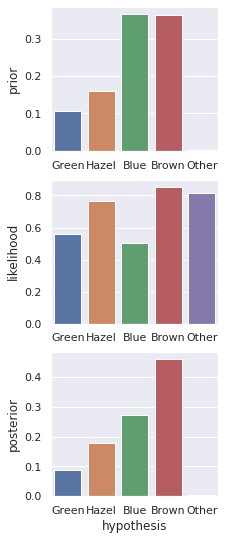

In [45]:
hyp = eyes.as_table().index
dat = eyes.as_table()
f, ax = plt.subplots(3,1,figsize=(3,9),)
sns.barplot(y='prior',     x=hyp,data=dat,ax=ax[0])
sns.barplot(y='likelihood',x=hyp,data=dat,ax=ax[1])
sns.barplot(y='posterior', x=hyp,data=dat,ax=ax[2]).set(xlabel='hypothesis')
plt.show()


## Example 13: Medical Tests - How well can a Covid test predict that you are actually infected ?

In [7]:
## Covid Example.
# Use figures from https://pubmed.ncbi.nlm.nih.gov/34242764/
# Sensitivity of the rapid antigen test was 65.3% and the specificity was 99.9% 
## Here let's use fictitious numbers of specificity=97.5, sensitivity=94.3

covid_test = BayesCalculator(['not infected','infected'],prior=[0.95,0.05])

## Likelihoods (for -ve test) are specifity, 1- sensitivity
## Likelihoods (for +ve test) are 1-specificity, sensitivity
covid_test = covid_test \
            .set_likelihood('Negative',[97.5,5.7]) \
            .set_likelihood('Positive',[2.5, 94.3])

In [8]:
covid_test = covid_test.update('Positive')
display(covid_test.as_table())

,prior,likelihood,posterior
not infected,0.95,2.50,0.33
infected,0.05,94.30,0.67


### testing

In [9]:
sensitivity = 0.943
specificity = 0.957
prevalence = np.linspace(0,1.,100)
infected_prob_pos = []
infected_prob_neg = []
for p in prevalence:
  test = BayesCalculator(['NI','I'],prior=[1-p,p]) \
          .set_likelihood('-',[specificity,    1.-sensitivity]) \
          .set_likelihood('+',[1.-specificity, sensitivity])
  test = test.update('+')
  infected_prob_pos.append(test.update('+').posterior()['I'])
  infected_prob_neg.append(test.update('-').posterior()['I'])


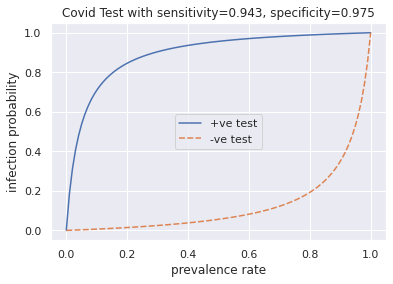

In [10]:
infected_prob = pd.DataFrame({'+ve test':infected_prob_pos, '-ve test':infected_prob_neg},index=prevalence)
sns.lineplot(data=infected_prob).set(xlabel='prevalence rate',
                                     ylabel='infection probability',
                                     title='Covid Test with sensitivity=0.943, specificity=0.975')
plt.show()

In [11]:
ss_values = np.linspace(0,1.,100)
covid_rate_sens = []
ss = np.linspace(0,1.,100)
covid_rate_sens = []
covid_rate_spec = []

for s in ss_values:
  specificity = 0.95
  sensitivity = s
  test = BayesCalculator(['NI','I'],prior=[0.95,0.05]) \
          .set_likelihood('-',[specificity,    1.-sensitivity]) \
          .set_likelihood('+',[1.-specificity, sensitivity])
  covid_rate_sens.append(test.update('+').posterior()['I'])

for s in ss_values:
  specificity = s
  sensitivity = 0.95
  test = BayesCalculator(['NI','I'],prior=[0.95,0.05]) \
          .set_likelihood('-',[specificity,    1.-sensitivity]) \
          .set_likelihood('+',[1.-specificity, sensitivity])
  covid_rate_spec.append(test.update('+').posterior()['I'])

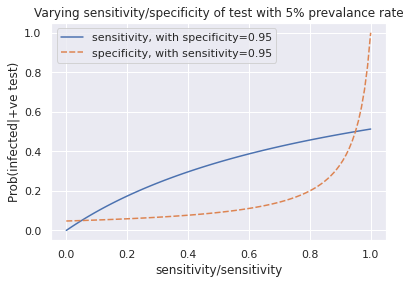

In [12]:
infected_prob = pd.DataFrame({'sensitivity, with specificity=0.95':covid_rate_sens, 
                              'specificity, with sensitivity=0.95':covid_rate_spec},
                              index=ss_values)
sns.lineplot(data=infected_prob).set(xlabel='sensitivity/sensitivity',
                                     ylabel='Prob(infected|+ve test)',
                                     title='Varying sensitivity/specificity of test with 5% prevalance rate')
plt.show()